Citation Request:
   This breast cancer domain was obtained from the University Medical Centre,
   Institute of Oncology, Ljubljana, Yugoslavia.  Thanks go to M. Zwitter and 
   M. Soklic for providing the data.  Please include this citation if you plan
   to use this database.

1. Title: Breast cancer data (Michalski has used this)

2. Sources: 
   -- Matjaz Zwitter & Milan Soklic (physicians)
      Institute of Oncology 
      University Medical Center
      Ljubljana, Yugoslavia
   -- Donors: Ming Tan and Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
   -- Date: 11 July 1988

3. Past Usage: (Several: here are some)
     -- Michalski,R.S., Mozetic,I., Hong,J., & Lavrac,N. (1986). The 
        Multi-Purpose Incremental Learning System AQ15 and its Testing 
        Application to Three Medical Domains.  In Proceedings of the 
        Fifth National Conference on Artificial Intelligence, 1041-1045,
        Philadelphia, PA: Morgan Kaufmann.
        -- accuracy range: 66%-72%
     -

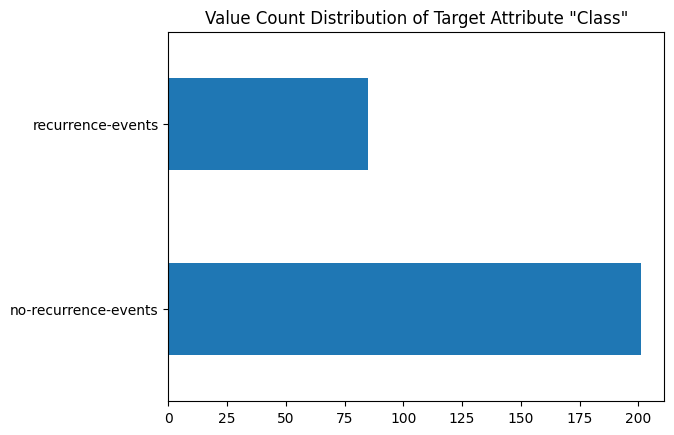

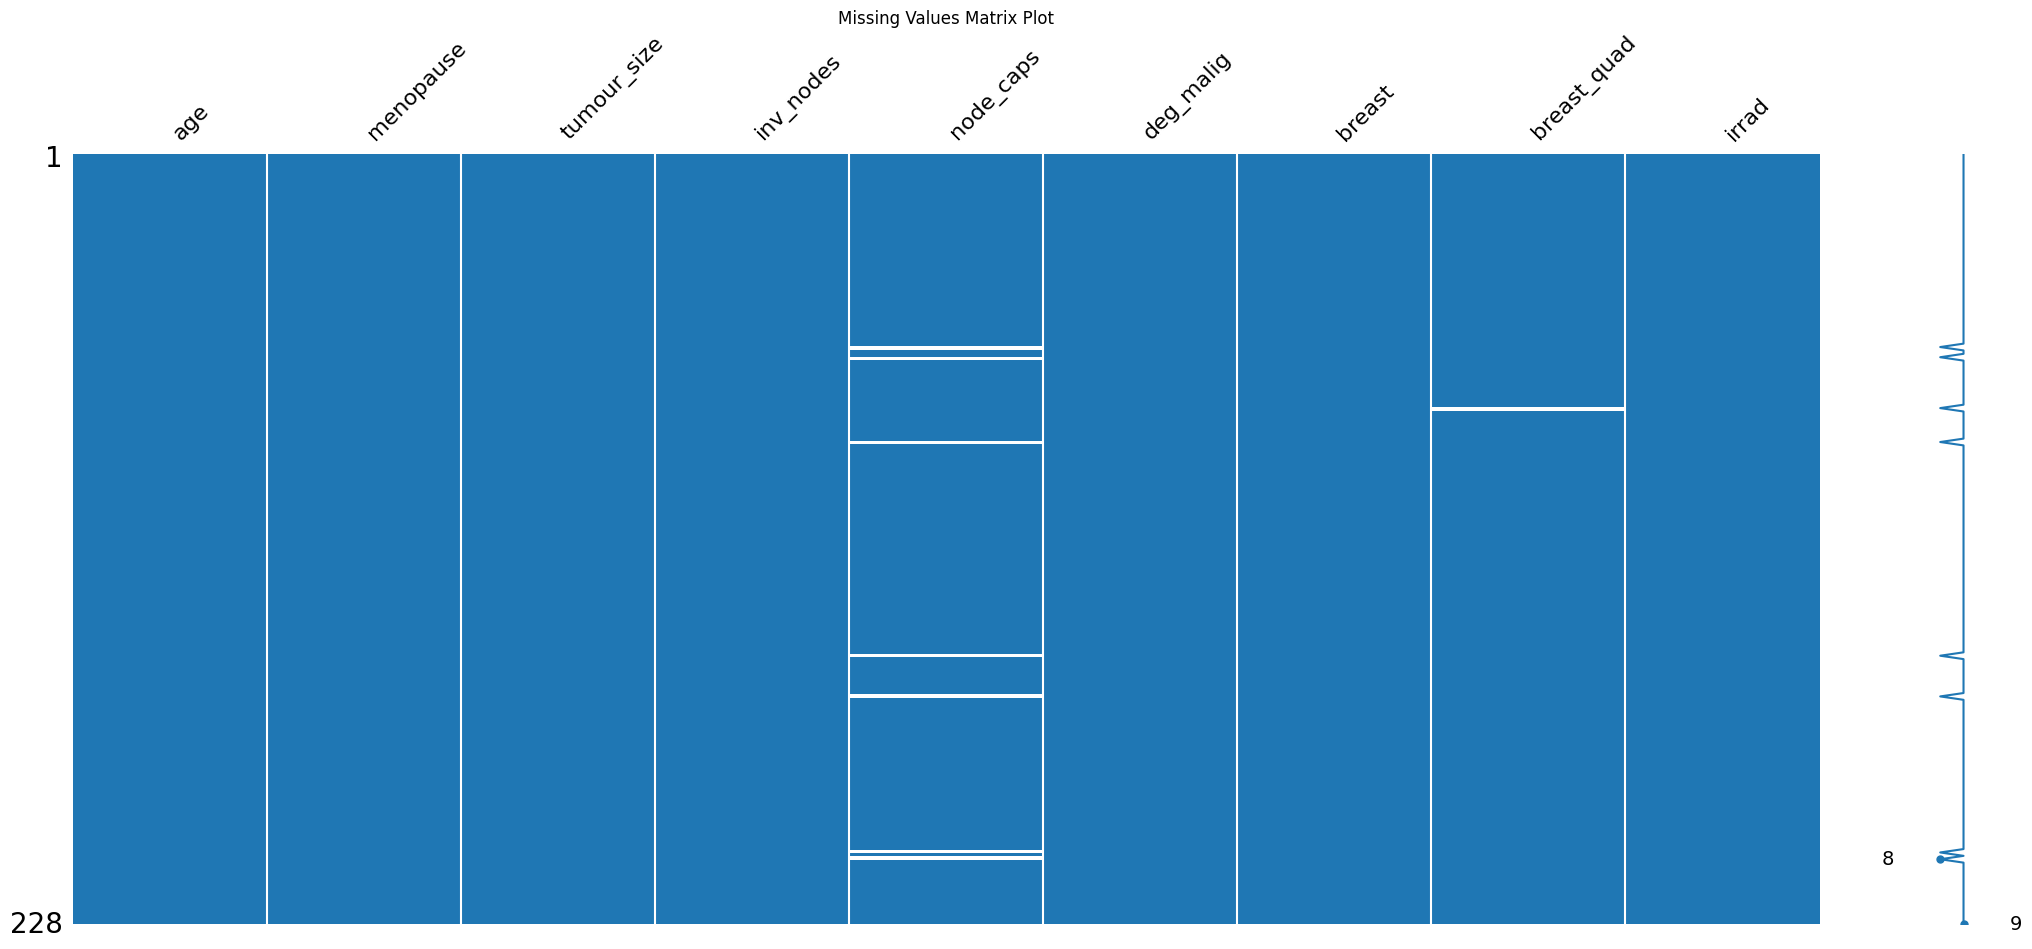

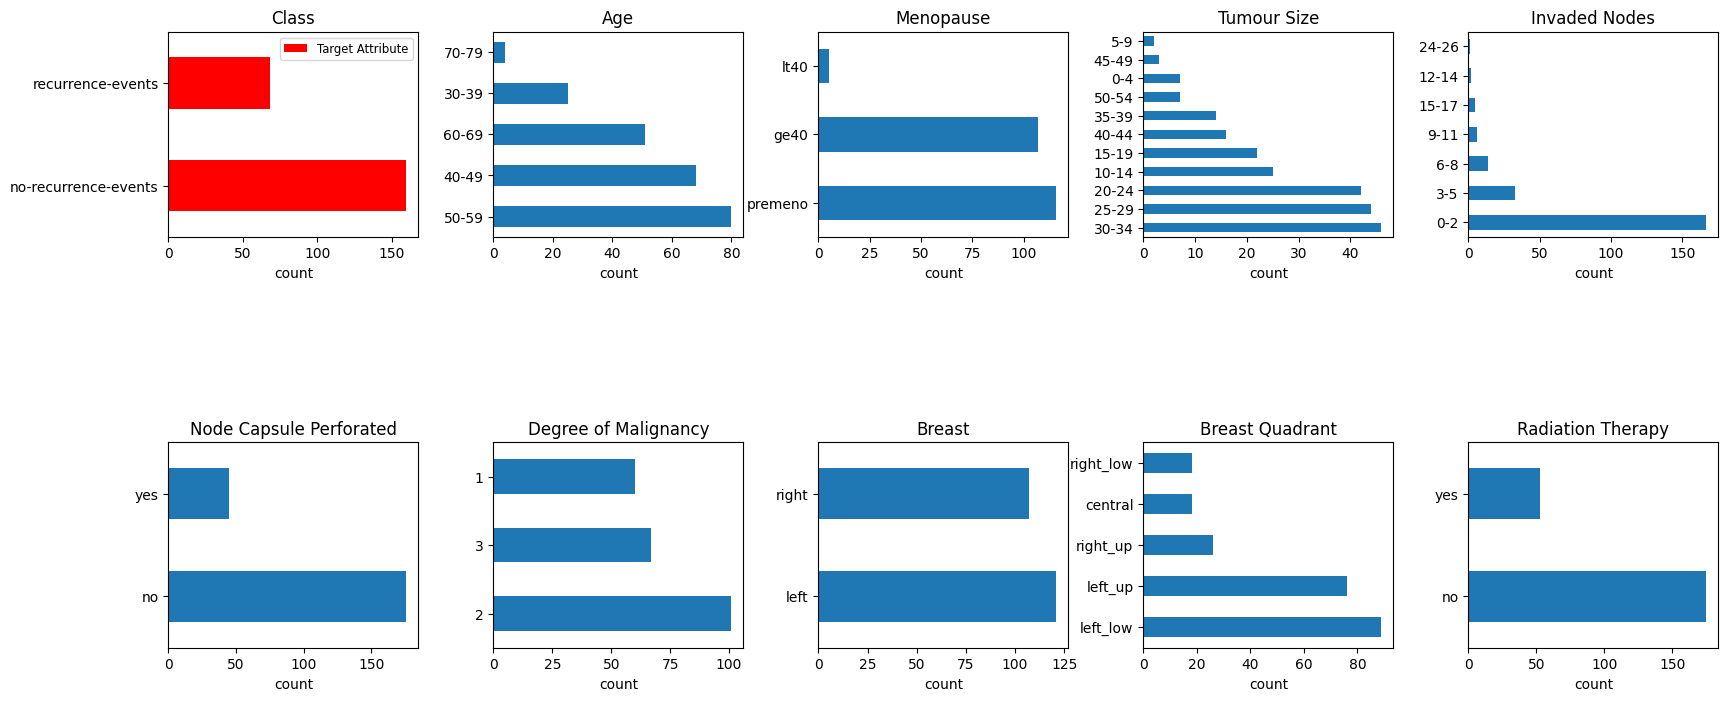

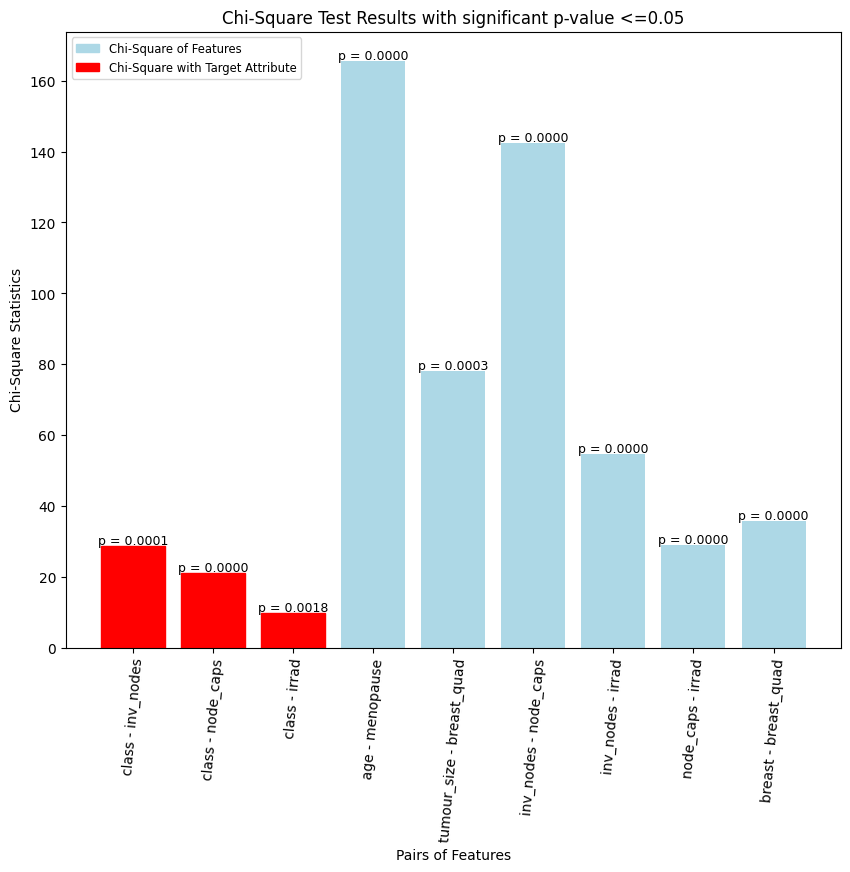

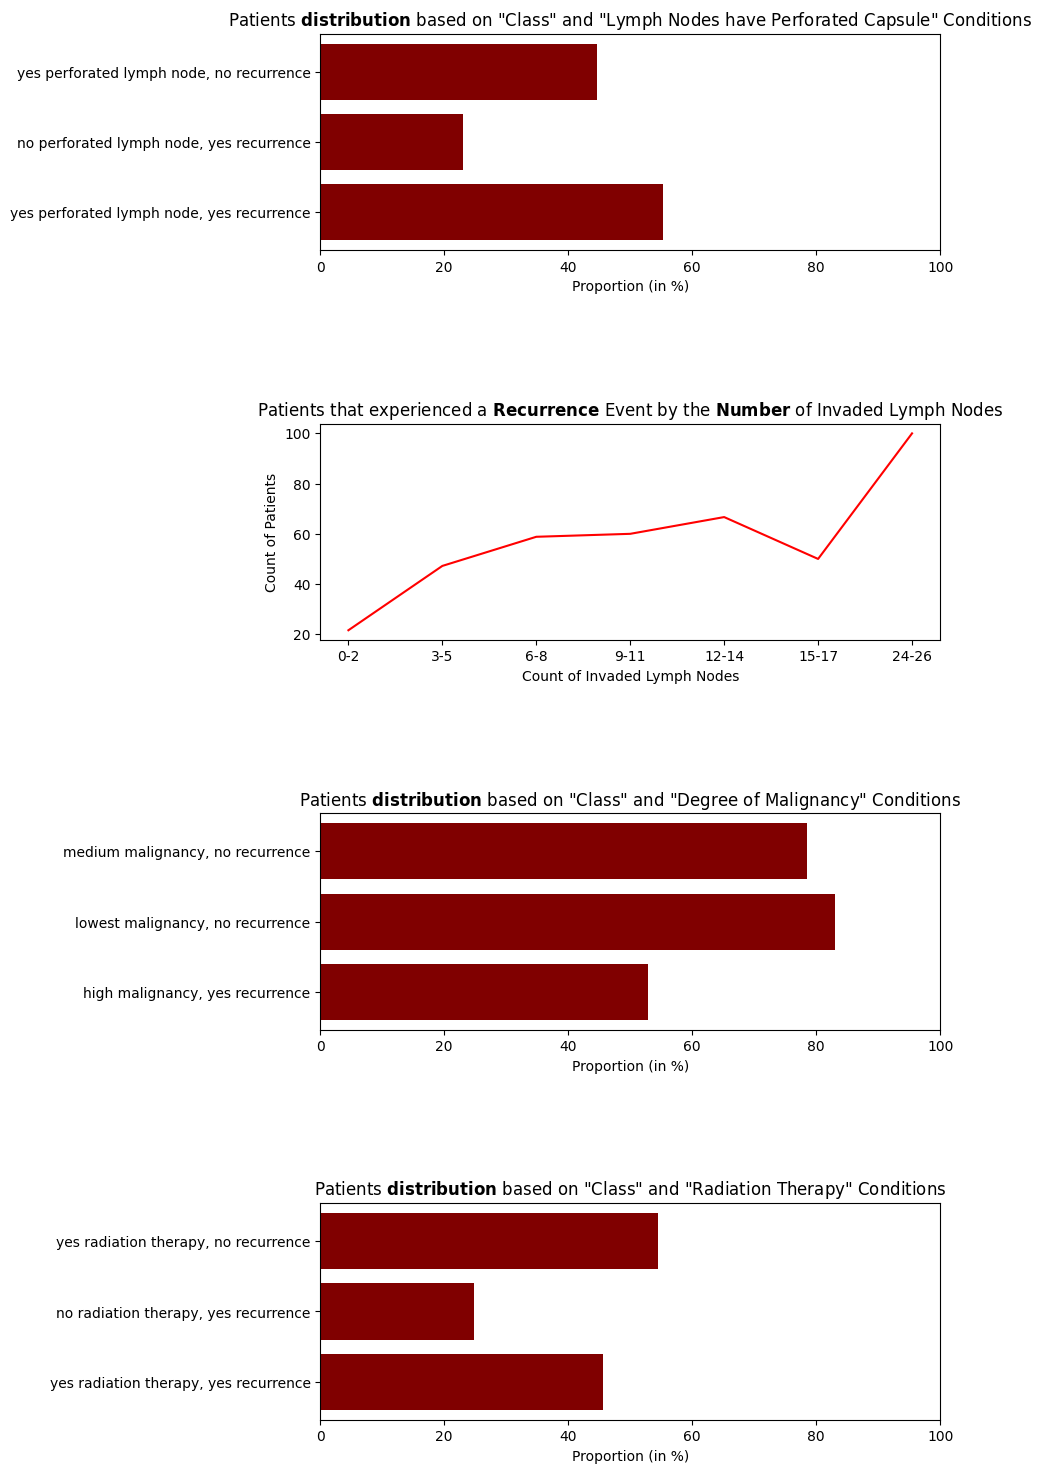

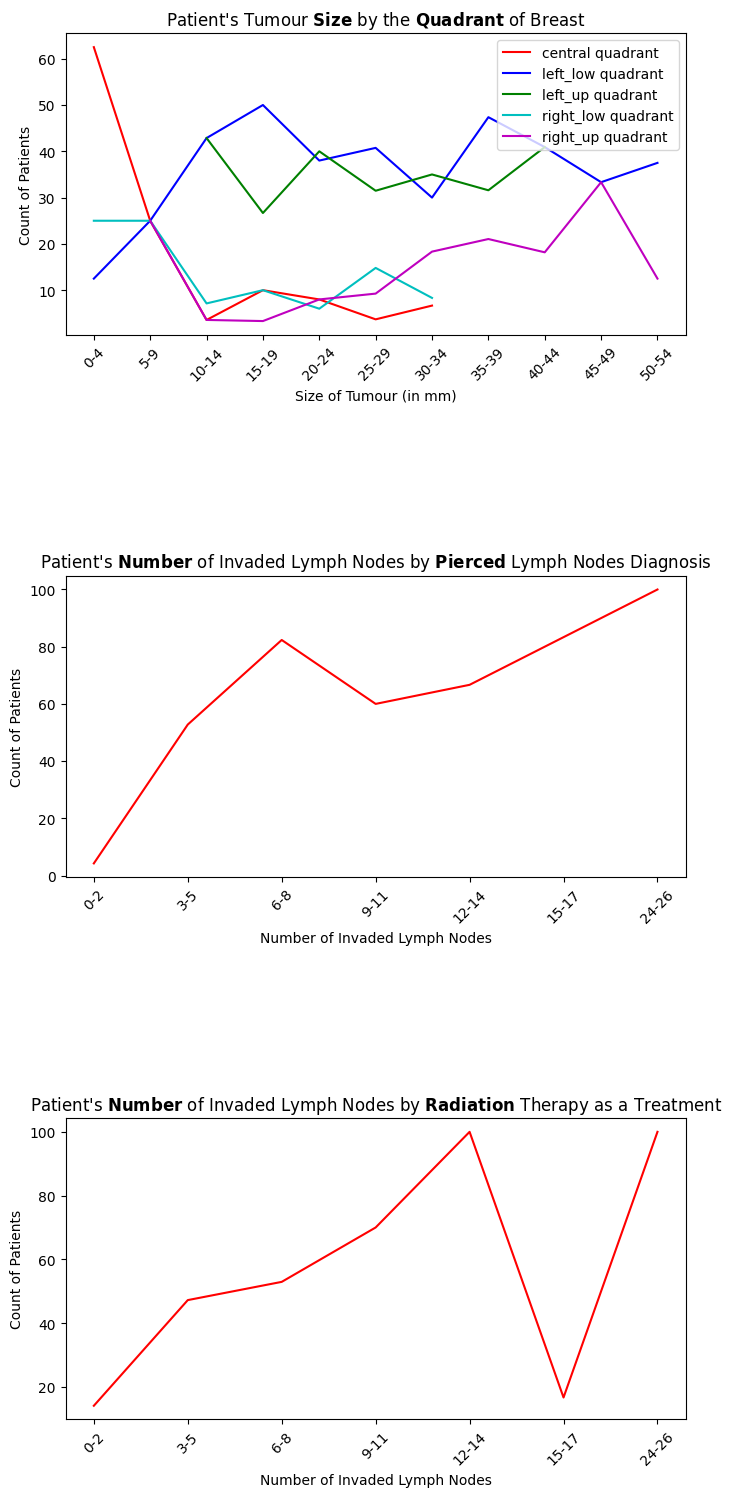

In [298]:
%run eda_prediction_recurrence_breast_cancer.ipynb

In [299]:
# import the necessary libraries
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, classification_report, recall_score, precision_score

from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

from IPython.display import display


- nominal features
    - menopause
    - node_caps
    - breast
    - breast_quad
    - irrad
    - class (*target feature*)
- ordinal features
    - age
    - tumour_size
    - inv_nodes
- numerical feature
    - deg_malig

#### Compute Feature Importance

Before identifying the most promising transformations I can make on features I want to have a look at feature importance

In [300]:
columns_to_keep = ['inv_nodes', 'node_caps', 'irrad', 'breast_quad', 'deg_malig', 'tumour_size']
X_train = X_train[columns_to_keep]

In [301]:
# Encode nominal features using one-hot encoding with drop_first=True
X_train_nominal = pd.get_dummies(X_train[['node_caps','breast_quad', 'irrad']])


# perform label encoding for ordinal features
label_encoder = preprocessing.LabelEncoder()
X_train_ordinal = X_train[['inv_nodes', 'tumour_size']]
for col in X_train_ordinal.columns:
    X_train_ordinal[col] = label_encoder.fit_transform(X_train_ordinal[col])


X_train_numerical = X_train[['deg_malig']]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [302]:
X_train_encoded = pd.concat([X_train_nominal, X_train_ordinal, X_train_numerical], axis=1)

In [303]:
X_train_encoded.head()

,node_caps_no,node_caps_yes,breast_quad_central,breast_quad_left_low,breast_quad_left_up,breast_quad_right_low,breast_quad_right_up,irrad_no,irrad_yes,inv_nodes,tumour_size,deg_malig
215,1,0,0,0,1,0,0,1,0,0,3,2
41,1,0,0,1,0,0,0,1,0,0,4,2
24,1,0,0,0,1,0,0,1,0,0,6,2
161,0,1,0,1,0,0,0,1,0,4,5,2
144,0,1,1,0,0,0,0,1,0,5,8,3


In [304]:
y_train_encoded = y_train.replace(['no-recurrence-events', 'recurrence-events'], [0,1])

In [305]:
# create a validation set to train and evaluate the model
X_train_eval, X_eval, y_train_eval, y_eval = train_test_split(X_train_encoded, y_train_encoded, test_size=0.2, stratify=y_train_encoded, random_state=42)

In [306]:
def normal_pred(model, X_train, y_train, X_test, y_test):
    # No Processing performed
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return model, report
    

def resampling(model, X_train, y_train, X_test, y_test):
    # Resampling using RandomOverSampler
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    model = model 
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_eval)
    report = classification_report(y_eval, y_pred, output_dict=True)
    return model, report
    

def smote(model, X_train, y_train, X_test, y_test):
    # Resampling using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train) 
    model = model 
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_eval)
    report = classification_report(y_eval, y_pred, output_dict=True)
    return model, report


def smotetomek(model, X_train, y_train, X_test, y_test):
    # Resampling using SMOTE
    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train) 
    model = model 
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_eval)
    report = classification_report(y_eval, y_pred, output_dict=True)
    return model, report


def smoteenn(model, X_train, y_train, X_test, y_test):
    # Resampling using SMOTEENN
    smote_enn = SMOTEENN(random_state=42)
    X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train) 
    model = model 
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_eval)
    report = classification_report(y_eval, y_pred, output_dict=True)
    return model, report


def ensemble(model, X_train, y_train, X_test, y_test):
    # Resampling using KMeansSMOTE
    kmeans_smote = KMeansSMOTE(random_state=42)
    X_resampled, y_resampled = kmeans_smote.fit_resample(X_train, y_train) 
    model = model
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_eval)
    report = classification_report(y_eval, y_pred, output_dict=True)
    return model, report


In [307]:
voting_clf = VotingClassifier(estimators=[('rfc', RandomForestClassifier()), ('knn', KNeighborsClassifier(n_neighbors=5))], voting='soft')

models = [RandomForestClassifier(), LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=5), SVC(kernel='linear', probability=True), voting_clf]

dfs = []
for model in models:
    _, report1 = normal_pred(model, X_train_eval, y_train_eval, X_eval, y_eval)
    _, report2 = resampling(model, X_train_eval, y_train_eval, X_eval, y_eval)
    _, report3 = smote(model, X_train_eval, y_train_eval, X_eval, y_eval)
    _, report4 = smotetomek(model, X_train_eval, y_train_eval, X_eval, y_eval)
    _, report5 = smoteenn(model, X_train_eval, y_train_eval, X_eval, y_eval)
    _, report6 = ensemble(model, X_train_eval, y_train_eval, X_eval, y_eval)

    df = pd.DataFrame({
        'processing': ['Normal', 'Random resampling', 'SMOTE resampling', 'SMOTETomek resampling', 'SMOTEENN Resampling', 'Ensemble Method'],
        'weighted avg_precision': [report1['weighted avg']['precision'], report2['weighted avg']['precision'], report3['weighted avg']['precision'], report4['weighted avg']['precision'], report5['weighted avg']['precision'], report6['weighted avg']['precision']],
        'weighted avg_recall': [report1['weighted avg']['recall'], report2['weighted avg']['recall'], report3['weighted avg']['recall'], report4['weighted avg']['recall'], report5['weighted avg']['recall'], report6['weighted avg']['recall']],
        'weighted avg_f1-score': [report1['weighted avg']['f1-score'], report2['weighted avg']['f1-score'], report3['weighted avg']['f1-score'], report4['weighted avg']['f1-score'], report5['weighted avg']['f1-score'], report6['weighted avg']['f1-score']],
        'precision_0': [report1['0']['precision'], report2['0']['precision'], report3['0']['precision'], report4['0']['precision'], report5['0']['precision'], report6['0']['precision']],
        'precision_1': [report1['1']['precision'], report2['1']['precision'], report3['1']['precision'], report4['1']['precision'], report5['1']['precision'], report6['1']['precision']],
        'recall_0': [report1['0']['recall'], report2['0']['recall'], report3['0']['recall'], report4['0']['recall'], report5['0']['recall'], report6['0']['recall']],
        'recall_1': [report1['1']['recall'], report2['1']['recall'], report3['1']['recall'], report4['1']['recall'], report5['1']['recall'], report6['1']['recall']],
        'f1-score_0': [report1['0']['f1-score'], report2['0']['f1-score'], report3['0']['f1-score'], report4['0']['f1-score'], report5['0']['f1-score'], report6['0']['f1-score']],
        'f1-score_1': [report1['1']['f1-score'], report2['1']['f1-score'], report3['1']['f1-score'], report4['1']['f1-score'], report5['1']['f1-score'], report6['1']['f1-score']],
        'support_0': [report1['0']['support'], report2['0']['support'], report3['0']['support'], report4['0']['support'], report5['0']['support'], report6['0']['support']],
        'support_1': [report1['1']['support'], report2['1']['support'], report3['1']['support'], report4['1']['support'], report5['1']['support'], report6['1']['support']]
    })

    df = df.set_index('processing')
    dfs.append(df)





# Concatenate all DataFrames
result = pd.concat(dfs, keys=[str(i) for i in range(len(dfs))])
result = result.round(2)

new_labels = {'0': 'RandomForestClassifier()', '1': 'LogisticRegression()', '2': 'DecisionTreeClassifier()', '3': 'KNeighborsClassifier()', '4': 'SVC()', '5': 'Voting Classifier'}

# Rename the index labels using the dictionary
result = result.rename(index=new_labels)



format_dict = {
    'weighted avg_precision': '{:.2f}',
    'weighted avg_recall': '{:.2f}',
    'weighted avg_f1-score': '{:.2f}',
    'precision_0': '{:.2f}',
    'precision_1': '{:.2f}',
    'recall_0': '{:.2f}',
    'recall_1': '{:.2f}',
    'f1-score_0': '{:.2f}',
    'f1-score_1': '{:.2f}',
}

for col in ['support_0', 'support_1']:
    format_dict[col] = '{}'

# Highlight the maximum value in dark green for each "weighted avg_f1-score" column across all DataFrames
max_f1 = result['weighted avg_f1-score'].max()
min_f1 = result['weighted avg_f1-score'].min()
highlighted = result.style.apply(lambda x: ['background-color: darkgreen; color: white;' if val >= max_f1 and val == x['weighted avg_f1-score'] else 'background-color: red; color: white;' if val <= min_f1 and val == x['weighted avg_f1-score'] else '' for val in x], axis=1).format(format_dict)


highlighted

              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.67      0.71      0.69        14

    accuracy                           0.80        46
   macro avg       0.77      0.78      0.77        46
weighted avg       0.81      0.80      0.81        46



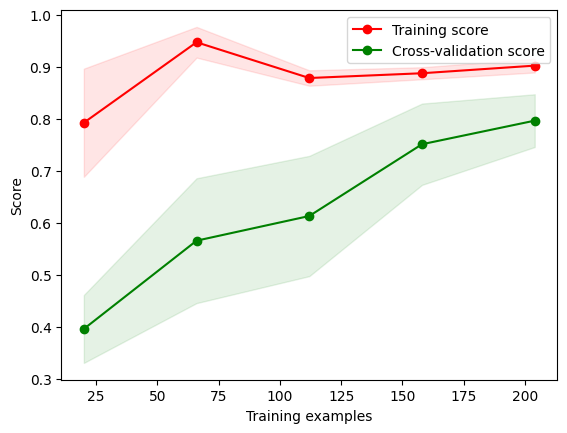

In [308]:
model = VotingClassifier(estimators=[('rfc', RandomForestClassifier()), ('knn', KNeighborsClassifier(n_neighbors=5))], voting='soft')


# performing resampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_eval, y_train_eval)

model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_eval)
report = classification_report(y_eval, y_pred)
y_score = model.predict_proba(X_eval)[:, 1]
print(report)




# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(model, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

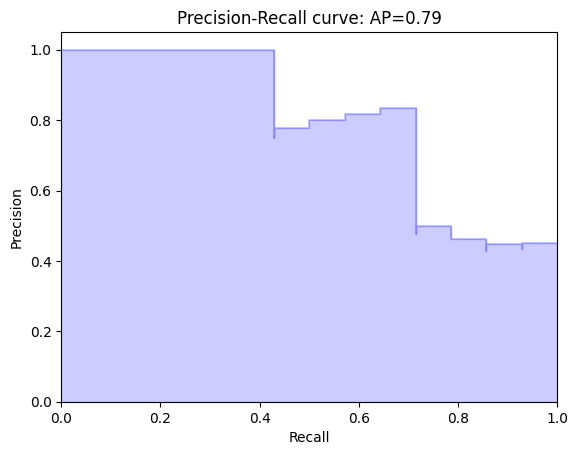

In [309]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(y_eval, y_score)
average_precision = average_precision_score(y_eval, y_score)

# plot the precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

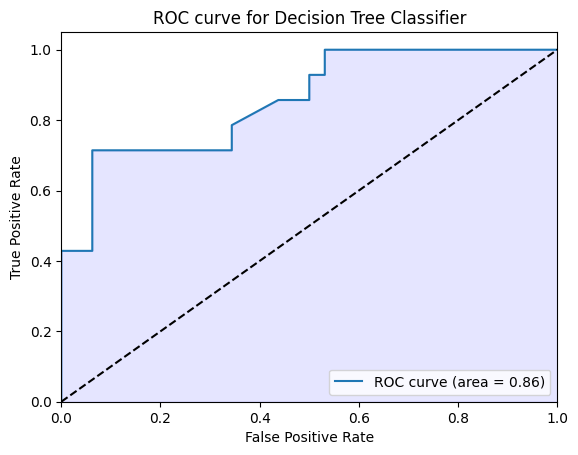

In [310]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_eval, y_score)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.fill_between(fpr, tpr, 0, color='blue', alpha=0.1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()


In [311]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_eval, y_eval, n_repeats=10, random_state=0)
importance_scores = result.importances_mean
sorted_idx = importance_scores.argsort()
for i in sorted_idx:
    print(f"{X_eval.columns[i]}: {round(importance_scores[i],4)}")

breast_quad_central: -0.0217
irrad_no: -0.0065
irrad_yes: -0.0065
node_caps_yes: -0.0043
breast_quad_right_low: 0.0
breast_quad_left_up: 0.0152
node_caps_no: 0.0217
inv_nodes: 0.0348
breast_quad_right_up: 0.0413
deg_malig: 0.0587
breast_quad_left_low: 0.0609
tumour_size: 0.1043


Permutation explainer: 47it [00:19,  1.15it/s]                        


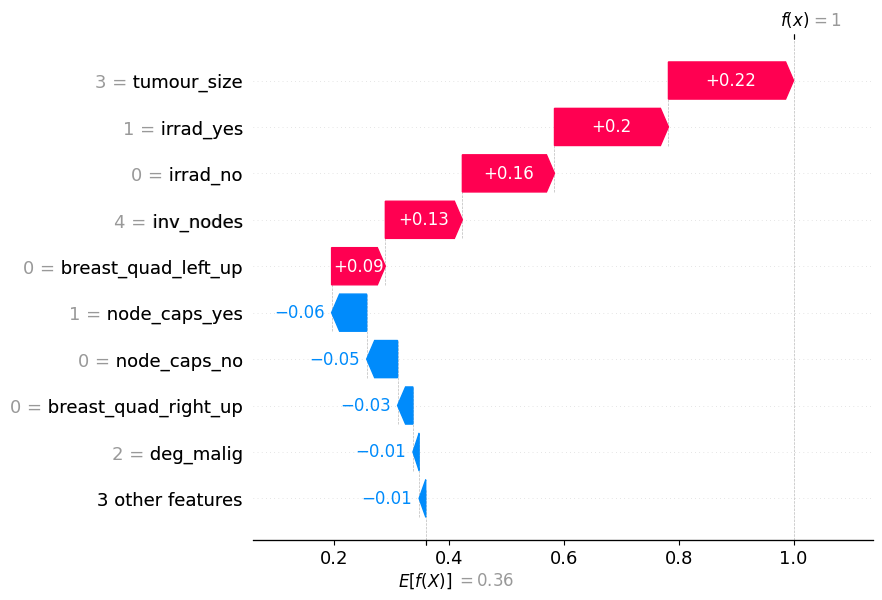

In [312]:

import shap

explainer = shap.Explainer(model.predict, X_train_resampled)
shap_values = explainer(X_eval)

# Plot the SHAP values for a single prediction
shap.plots.waterfall(shap_values[0])


In [313]:
model = VotingClassifier(estimators=[('rfc', RandomForestClassifier()), ('knn', KNeighborsClassifier(n_neighbors=5))], voting='soft')

# define the hyperparameters to search over
param_grid = {
    'rfc__n_estimators': [50, 200, 300, 500],
    'rfc__max_depth': [3, 8, 15],
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__min_samples_split': [2, 6, 10],
    'rfc__min_samples_leaf': [10, 20, 30],
    'knn__n_neighbors': [5, 7],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'brute']
}
# define the cross-validation scheme
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# define the scoring metric
scorer = make_scorer(f1_score)

# perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scorer, n_jobs=-1)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_eval, y_train_eval)

grid_search.fit(X_train_resampled, y_train_resampled)
best_params = grid_search.best_params_



# print the best hyperparameters and F1 score
print("Best hyperparameters:", best_params)
print("Best F1 score:", round(grid_search.best_score_, 2))


Best hyperparameters: {'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'distance', 'rfc__criterion': 'gini', 'rfc__max_depth': 3, 'rfc__min_samples_leaf': 20, 'rfc__min_samples_split': 10, 'rfc__n_estimators': 50}
Best F1 score: 0.78


##### YOU HAVE TO DO THE Test Pipeline

In [314]:
X_test = X_test[columns_to_keep]                                                                                                            

X_test_nominal = pd.get_dummies(X_test[['node_caps','breast_quad', 'irrad']])


# perform label encoding for ordinal features
label_encoder = preprocessing.LabelEncoder()
X_test_ordinal = X_test[['inv_nodes', 'tumour_size']]
for col in X_test_ordinal.columns:
    X_test_ordinal[col] = label_encoder.fit_transform(X_test_ordinal[col])


X_test_numerical = X_test[['deg_malig']]                                                                                                
X_test_encoded = pd.concat([X_test_nominal, X_test_ordinal, X_test_numerical], axis=1)      

y_test_encoded = y_test.replace(['no-recurrence-events', 'recurrence-events'], [0,1])                              




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [315]:
rfc_best = RandomForestClassifier(n_estimators=best_params['rfc__n_estimators'],
                                    max_depth=best_params['rfc__max_depth'], 
                                    criterion=best_params['rfc__criterion'],
                                    min_samples_split=best_params['rfc__min_samples_split'],
                                    min_samples_leaf=best_params['rfc__min_samples_leaf'])
                                    
knn_best = KNeighborsClassifier(n_neighbors=best_params['knn__n_neighbors'],
                                    weights=best_params['knn__weights'],
                                    algorithm=best_params['knn__algorithm'] )


# create a new VotingClassifier object with the best hyperparameters
best_model = VotingClassifier(estimators=[('rfc', rfc_best), ('knn', knn_best)], voting='soft')

# fit the new VotingClassifier object on the entire training data
best_model.fit(X_train_resampled, y_train_resampled)


#model.fit(X_train_resampled, y_train_resampled)
y_pred = best_model.predict(X_test_encoded)


target_names = ['0: no-recurrence-events', '1: recurrence-events']
report = classification_report(y_test_encoded, y_pred, target_names=target_names)
print('Model Performance on Unseen Data')
print(report)

Model Performance on Unseen Data
                         precision    recall  f1-score   support

0: no-recurrence-events       0.73      0.73      0.73        41
   1: recurrence-events       0.35      0.35      0.35        17

               accuracy                           0.62        58
              macro avg       0.54      0.54      0.54        58
           weighted avg       0.62      0.62      0.62        58



The model seems to start correctely predict false negatives and false positives for the patients that are likely to experience recurrence in real-world. Some work needs to be done to increase the possibility of false positives and negatives for patients not likely to experience a recurrence in real-world.

It's also important to consider the potential consequences of false positives, as this can lead to unnecessary medical interventions and anxiety for the patient. Radiation therapy might be used when It wasn't necessary as a prevention method.

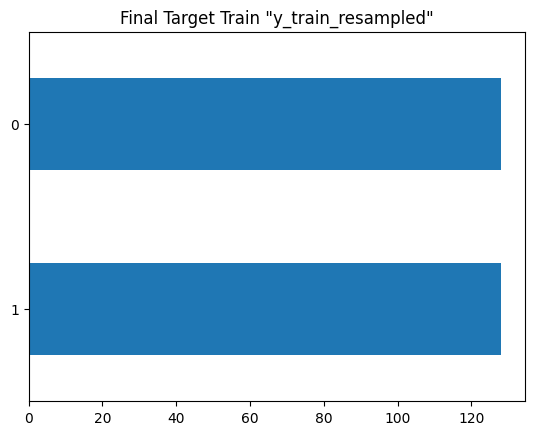

In [316]:
y_train_res = y_train_resampled.value_counts()
y_train_res.plot.barh()
plt.title('Final Target Train "y_train_resampled"')
plt.show()

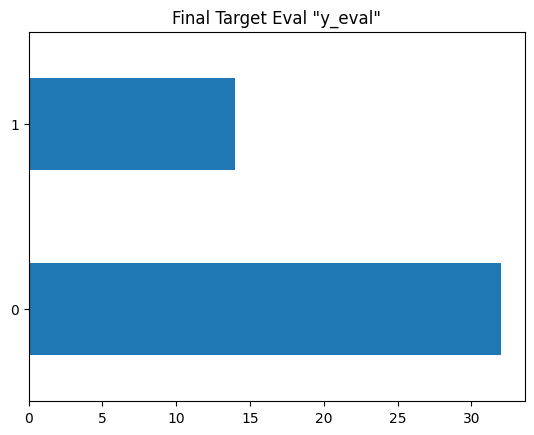

In [317]:
y_eval_res = y_eval.value_counts()
y_eval_res.plot.barh()
plt.title('Final Target Eval "y_eval"')
plt.show()

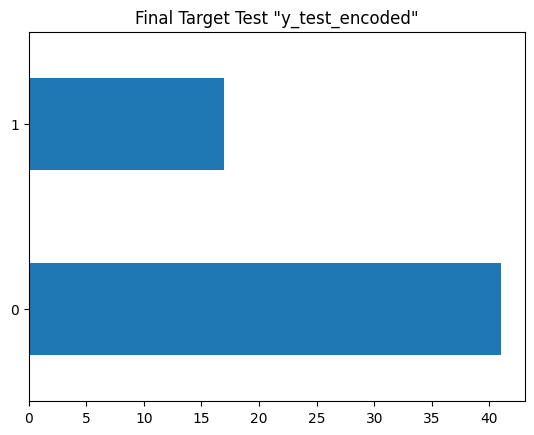

In [318]:
y_test_res = y_test_encoded.value_counts()
y_test_res.plot.barh()
plt.title('Final Target Test "y_test_encoded"')
plt.show()